<a href="https://colab.research.google.com/github/yagoojoy/PINN_Taylor-Green-Vortex/blob/main/260105_Meeting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

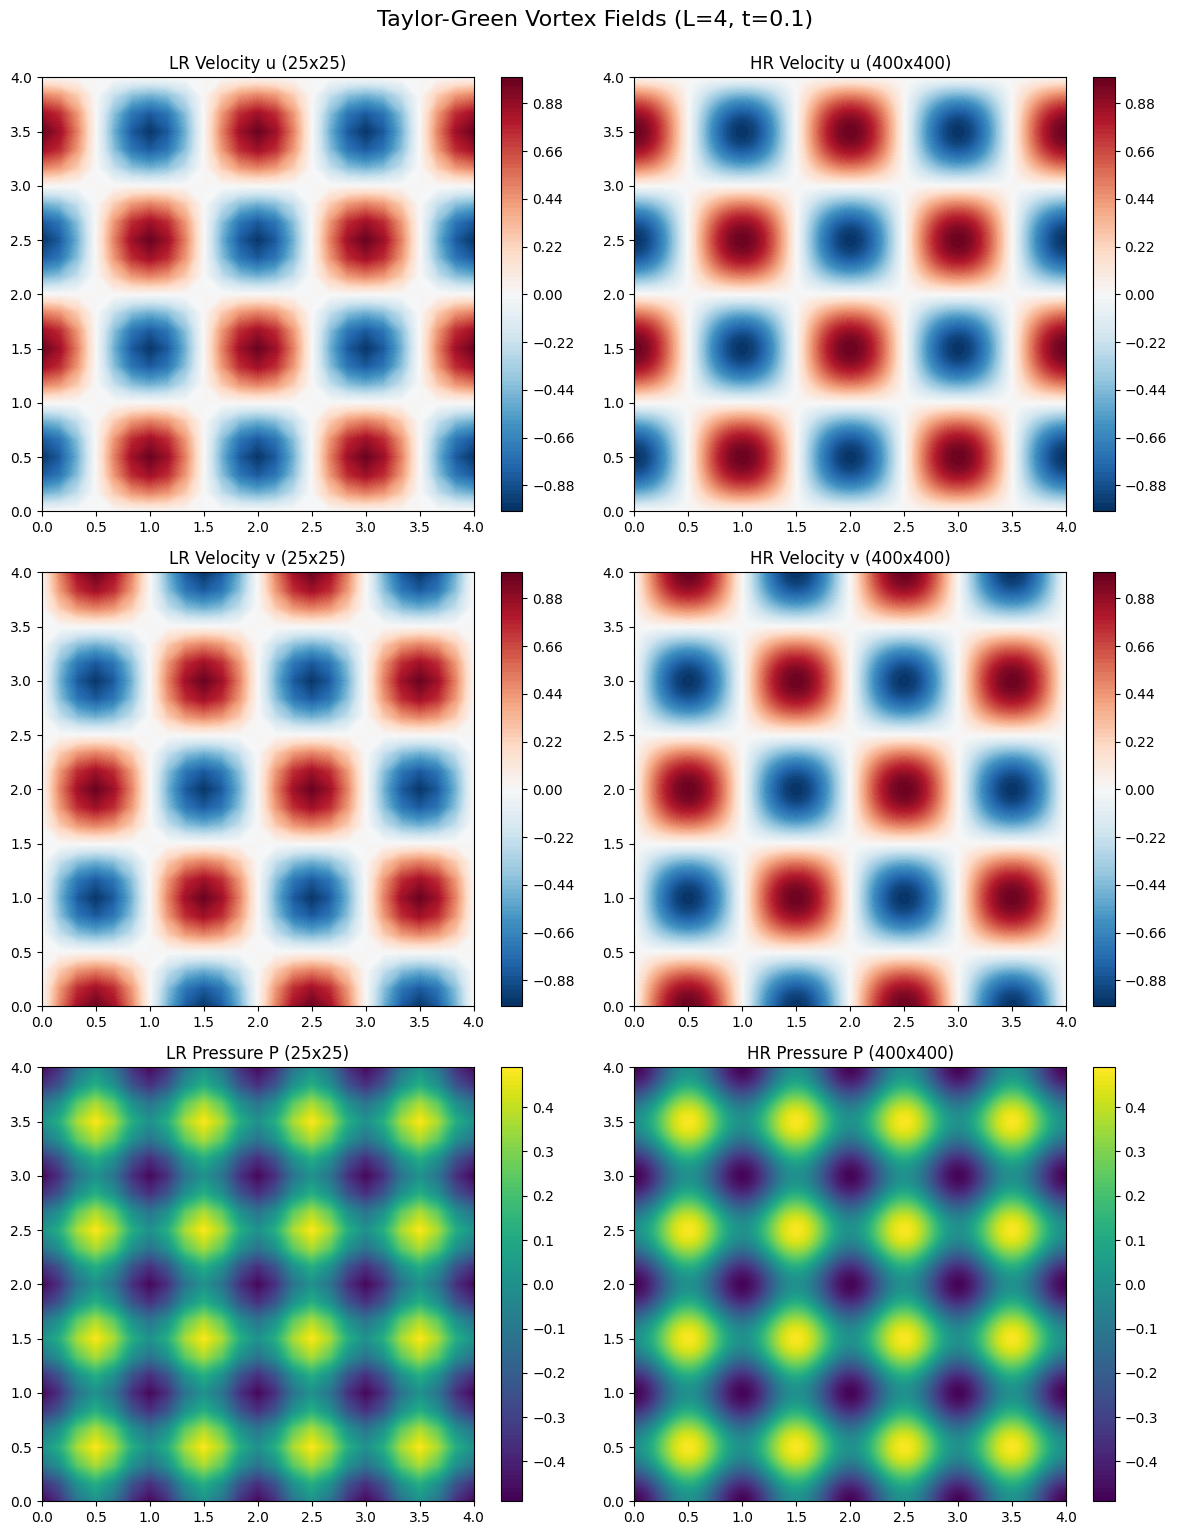

--- 데이터 저장 성공 ---
1. LR 데이터 파일: TGV_LR_25x25_L4.csv
2. HR 데이터 파일: TGV_HR_400x400_L4.csv


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_tgv_data(nx, ny, t, L=4, nu=0.01):
    """
    Taylor-Green Vortex 해석해를 생성하는 함수
    """
    x = np.linspace(0, L, nx)
    y = np.linspace(0, L, ny)
    X, Y = np.meshgrid(x, y)

    # Taylor-Green Vortex 해석해 정의
    u = -np.cos(np.pi * X) * np.sin(np.pi * Y) * np.exp(-2 * np.pi**2 * nu * t)
    v =  np.sin(np.pi * X) * np.cos(np.pi * Y) * np.exp(-2 * np
                                                        .pi**2 * nu * t)
    p = -0.25 * (np.cos(2 * np.pi * X) + np.cos(2 * np.pi * Y)) * np.exp(-4 * np.pi**2 * nu * t)

    return X, Y, u, v, p

def convert_to_dataframe(X, Y, u, v, p, t):
    """
    격자 데이터를 Pandas DataFrame으로 변환하는 함수 (평탄화)
    """
    data = {
        'x': X.flatten(),
        'y': Y.flatten(),
        't': np.full(X.size, t),
        'u': u.flatten(),
        'v': v.flatten(),
        'p': p.flatten()
    }
    return pd.DataFrame(data)

# --- 1. 설정 값 및 데이터 생성 ---
L_val = 4
t_fixed = 0.1
nu_val = 0.01
LR_SIZE = 25  # 25x25 (625 points)
HR_SIZE = 400 # 400x400 (160,000 points)

X_lr, Y_lr, u_lr, v_lr, p_lr = generate_tgv_data(LR_SIZE, LR_SIZE, t_fixed, L=L_val, nu=nu_val)
X_hr, Y_hr, u_hr, v_hr, p_hr = generate_tgv_data(HR_SIZE, HR_SIZE, t_fixed, L=L_val, nu=nu_val)

# --- 2. 시각화: 3행(u, v, p) x 2열(LR, HR) ---
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

plots = [
    (u_lr, u_hr, 'Velocity u', 'RdBu_r'),
    (v_lr, v_hr, 'Velocity v', 'RdBu_r'),
    (p_lr, p_hr, 'Pressure P', 'viridis')
]

for i, (data_lr, data_hr, title, cmap) in enumerate(plots):
    # LR Plot (좌측 열)
    im_lr = axes[i, 0].contourf(X_lr, Y_lr, data_lr, levels=100, cmap=cmap)
    axes[i, 0].set_title(f'LR {title} ({LR_SIZE}x{LR_SIZE})')
    fig.colorbar(im_lr, ax=axes[i, 0])

    # HR Plot (우측 열)
    im_hr = axes[i, 1].contourf(X_hr, Y_hr, data_hr, levels=100, cmap=cmap)
    axes[i, 1].set_title(f'HR {title} ({HR_SIZE}x{HR_SIZE})')
    fig.colorbar(im_hr, ax=axes[i, 1])

plt.tight_layout()
plt.suptitle(f'Taylor-Green Vortex Fields (L={L_val}, t={t_fixed})', fontsize=16, y=1.02)
plt.show()

# --- 3. 데이터 저장 (CSV 형식) ---
# 기존 오류 지점 수정: save_to_excel 대신 convert_to_dataframe 사용
df_lr = convert_to_dataframe(X_lr, Y_lr, u_lr, v_lr, p_lr, t_fixed)
df_hr = convert_to_dataframe(X_hr, Y_hr, u_hr, v_hr, p_hr, t_fixed)

lr_filename = f'TGV_LR_{LR_SIZE}x{LR_SIZE}_L{L_val}.csv'
hr_filename = f'TGV_HR_{HR_SIZE}x{HR_SIZE}_L{L_val}.csv'

df_lr.to_csv(lr_filename, index=False)
df_hr.to_csv(hr_filename, index=False)

print(f"--- 데이터 저장 성공 ---")
print(f"1. LR 데이터 파일: {lr_filename}")
print(f"2. HR 데이터 파일: {hr_filename}")

현재 사용 중인 장치: cuda
1단계: Adam 최적화 진행...
Adam Epoch 0 | Loss: 5.813430
Adam Epoch 500 | Loss: 0.032446
Adam Epoch 1000 | Loss: 0.008170
Adam Epoch 1500 | Loss: 0.027048
Adam Epoch 2000 | Loss: 0.006727
Adam Epoch 2500 | Loss: 0.006773
✔️ Adam 완료 (소요 시간: 699.87초)

2단계: L-BFGS 최적화 진행 (정밀 수렴)...
✔️ L-BFGS 완료 (소요 시간: 416.76초)

🚀 학습 완료 보고서 (Fourier Feature 적용됨)
총 소요 시간: 18.61분
------------------------------
✅ Final Data Loss    : 0.00000003
✅ Final Physics Loss : 0.00003584
✅ Final Total Loss   : 0.00000393


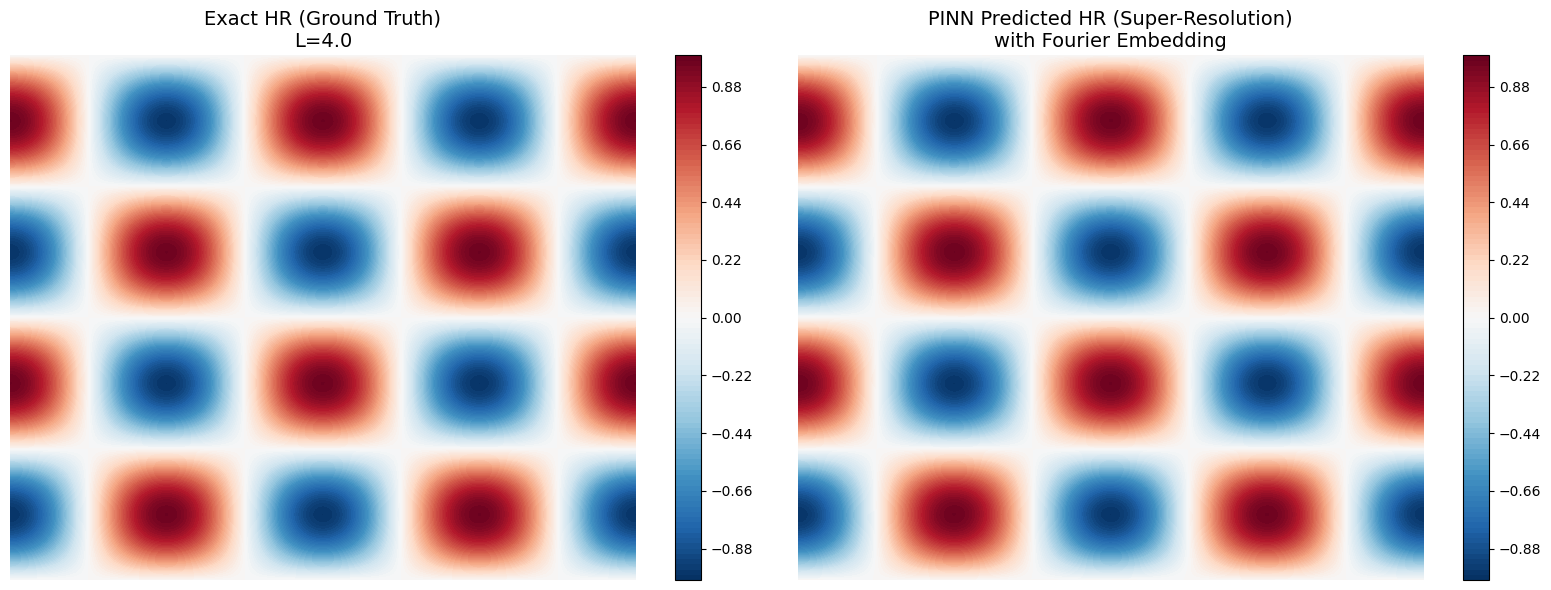

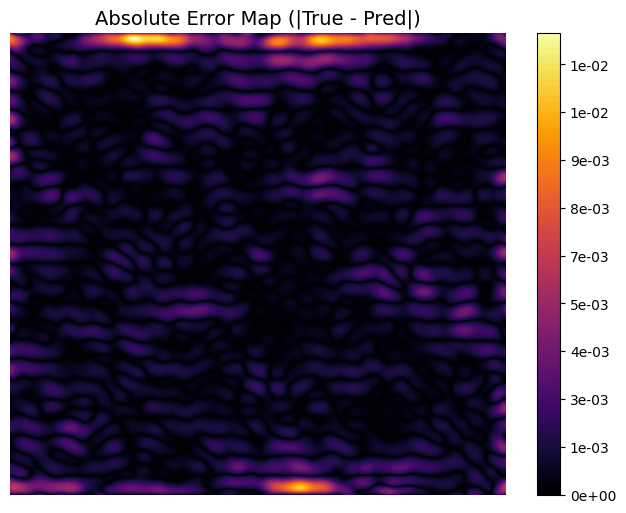

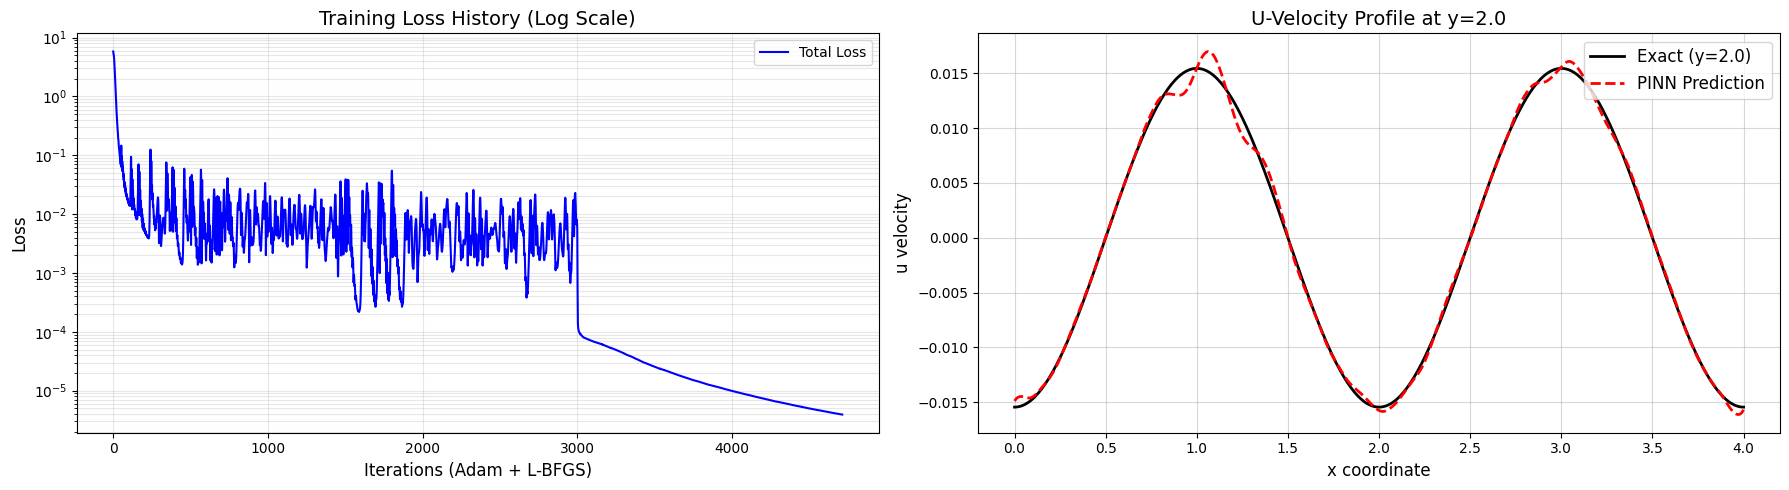


📊 Slice Plot Analysis (at y=2.0):
   - L2 Relative Error at this section: 5.0197 %


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# ==========================================
# 0. GPU 설정 및 환경 준비
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 사용 중인 장치: {device}")

# ==========================================
# 1. Fourier Feature Embedding (고주파 학습 해결사)
# ==========================================
class FourierEmbedding(nn.Module):
    def __init__(self, in_channels, scale=5.0): # scale이 클수록 고주파 패턴을 잘 잡음
        super().__init__()
        # 학습되지 않는 고정된 주파수 행렬 B 생성 (가우시안 분포)
        # 입력(3) -> 출력(256쌍 = 512차원)
        self.register_buffer("B", torch.randn(in_channels, 256) * scale)

    def forward(self, x):
        # 입력 x (Batch, 3) -> 투영 -> 2 * pi * B * x
        x_proj = 2 * np.pi * x @ self.B
        # [sin, cos] 형태로 변환하여 고주파 정보 생성 (Batch, 512)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ==========================================
# 2. PINN 모델 클래스 정의 (Fourier 적용)
# ==========================================
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # 입력(3) -> Fourier(256) -> MLP
        self.embedding = FourierEmbedding(in_channels=3, scale=5.0)

        self.net = nn.Sequential(
            nn.Linear(512, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 3) # 출력: u, v, p
        )

    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)
        # 1. 임베딩 층 통과
        embedded_inputs = self.embedding(inputs)
        # 2. MLP 통과
        out = self.net(embedded_inputs)
        return out[:, 0:1], out[:, 1:2], out[:, 2:3]

# ==========================================
# 3. 물리 법칙(PDE) 손실 함수 정의 (주기적 경계 조건 추가됨)
# ==========================================
def get_pde_loss(model, x, y, t, nu=0.01):
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)

    u, v, p = model(x, y, t)

    # 1차, 2차 미분 계산 (기존과 동일)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]

    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    v_t = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x.sum(), x, create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y.sum(), y, create_graph=True)[0]

    p_x = torch.autograd.grad(p.sum(), x, create_graph=True)[0]
    p_y = torch.autograd.grad(p.sum(), y, create_graph=True)[0]

    # 잔차 계산
    f_c = u_x + v_y
    f_u = u_t + (u * u_x + v * u_y) + p_x - nu * (u_xx + u_yy)
    f_v = v_t + (u * v_x + v * v_y) + p_y - nu * (v_xx + v_yy)

    # BC Loss 제거하고 순수 PDE Loss만 반환
    return torch.mean(f_c**2) + torch.mean(f_u**2) + torch.mean(f_v**2)

# ==========================================
# 4. 데이터 로딩 및 정규화
# ==========================================
L_max = 4.0 # 정규화 상수
try:
    df_lr = pd.read_csv('TGV_LR_25x25_L4.csv')
    df_hr = pd.read_csv('TGV_HR_400x400_L4.csv')
except FileNotFoundError:
    print("오류: CSV 파일이 없습니다. 이전 셀을 먼저 실행해주세요.")

# 훈련 데이터 (LR 25x25) - 정규화 적용
x_train = torch.tensor(df_lr['x'].values / L_max, dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(df_lr['y'].values / L_max, dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(df_lr['t'].values, dtype=torch.float32).view(-1, 1).to(device)
u_train = torch.tensor(df_lr['u'].values, dtype=torch.float32).view(-1, 1).to(device)
v_train = torch.tensor(df_lr['v'].values, dtype=torch.float32).view(-1, 1).to(device)
p_train = torch.tensor(df_lr['p'].values, dtype=torch.float32).view(-1, 1).to(device)

# 물리 학습점 (Collocation points - 10000개)
x_phys = torch.rand(10000, 1).to(device).requires_grad_(True)
y_phys = torch.rand(10000, 1).to(device).requires_grad_(True)
t_phys = (torch.ones(10000, 1) * 0.1).to(device).requires_grad_(True)

# ==========================================
# 5. 모델 및 옵티마이저 설정
# ==========================================
model = PINN().to(device)
adam = optim.Adam(model.parameters(), lr=1e-3)
lbfgs = optim.LBFGS(model.parameters(),
                    lr=1,
                    max_iter=20000,
                    max_eval=50000,
                    line_search_fn='strong_wolfe',
                    tolerance_grad=1e-9,
                    tolerance_change=1e-9,
                    history_size=100)

def closure():
    adam.zero_grad()
    lbfgs.zero_grad()
    u_p, v_p, p_p = model(x_train, y_train, t_train)

    # [중요] Data Loss 가중치 강화 (초기 형상을 잡기 위해)
    loss_d = torch.mean((u_train-u_p)**2 + (v_train-v_p)**2 + (p_train-p_p)**2)
    loss_p = get_pde_loss(model, x_phys, y_phys, t_phys)

    # Data: 10.0, Physics: 0.1
    loss = 10.0 * loss_d + 0.1 * loss_p
    loss.backward()
    return loss

# ==========================================
# 6. 단계별 학습 및 시간 측정 (Loss 기록 추가)
# ==========================================
loss_history = [] # Loss 값을 저장할 리스트

total_start_time = time.time()

# [1단계: Adam]
print("1단계: Adam 최적화 진행...")
adam_start_time = time.time()

for epoch in range(3000):
    # Adam은 step마다 closure를 호출하지 않으므로 수동으로 기록
    adam.zero_grad()
    loss = closure() # 여기서 loss 계산 및 backward 진행 (closure 내부에서 append 하지 않도록 주의)
    loss_history.append(loss.item()) # 기록
    adam.step()

    if epoch % 500 == 0:
        print(f"Adam Epoch {epoch} | Loss: {loss.item():.6f}")

adam_end_time = time.time()
print(f"✔️ Adam 완료 (소요 시간: {adam_end_time - adam_start_time:.2f}초)")

# [2단계: L-BFGS]
# L-BFGS는 closure를 반복 호출하므로, closure를 감싸는 함수를 만들어 기록
print("\n2단계: L-BFGS 최적화 진행 (정밀 수렴)...")

def closure_with_track():
    loss = closure()
    loss_history.append(loss.item()) # L-BFGS 내부 반복마다 기록
    return loss

lbfgs_start_time = time.time()
lbfgs.step(closure_with_track)
lbfgs_end_time = time.time()
print(f"✔️ L-BFGS 완료 (소요 시간: {lbfgs_end_time - lbfgs_start_time:.2f}초)")

total_end_time = time.time()

# ==========================================
# 7. 최종 수치 분석 (Final Loss)
# ==========================================
model.eval()
with torch.no_grad():
    u_p, v_p, p_p = model(x_train, y_train, t_train)
    final_loss_d = torch.mean((u_train-u_p)**2 + (v_train-v_p)**2 + (p_train-p_p)**2)

model.train() # PDE 계산용
final_loss_p = get_pde_loss(model, x_phys, y_phys, t_phys)
final_total_loss = 10.0 * final_loss_d + 0.1 * final_loss_p

print("\n" + "="*50)
print(f"🚀 학습 완료 보고서 (Fourier Feature 적용됨)")
print(f"총 소요 시간: {(total_end_time - total_start_time)/60:.2f}분")
print("-" * 30)
print(f"✅ Final Data Loss    : {final_loss_d.item():.8f}")
print(f"✅ Final Physics Loss : {final_loss_p.item():.8f}")
print(f"✅ Final Total Loss   : {final_total_loss.item():.8f}")
print("="*50)

# ==========================================
# 8. 시각화 (HR 예측 결과 비교)
# ==========================================
# HR 도메인 데이터 준비
x_test = torch.tensor(df_hr['x'].values / L_max, dtype=torch.float32).view(-1, 1).to(device)
y_test = torch.tensor(df_hr['y'].values / L_max, dtype=torch.float32).view(-1, 1).to(device)
t_test = torch.tensor(df_hr['t'].values, dtype=torch.float32).view(-1, 1).to(device)

model.eval() # 평가 모드
with torch.no_grad():
    u_pinn, v_pinn, p_pinn = model(x_test, y_test, t_test)

# 시각화를 위한 변환 (400x400)
u_pinn_img = u_pinn.cpu().numpy().reshape(400, 400)
u_exact_img = df_hr['u'].values.reshape(400, 400)

plt.figure(figsize=(16, 6))

# 왼쪽: 정답
plt.subplot(1, 2, 1)
plt.contourf(u_exact_img, levels=100, cmap='RdBu_r')
plt.title(f"Exact HR (Ground Truth)\nL={L_max}", fontsize=14)
plt.colorbar()
plt.axis('off')

# 오른쪽: PINN 예측
plt.subplot(1, 2, 2)
plt.contourf(u_pinn_img, levels=100, cmap='RdBu_r')
plt.title(f"PINN Predicted HR (Super-Resolution)\nwith Fourier Embedding", fontsize=14)
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

# 오차 맵 (Error Map)
plt.figure(figsize=(8, 6))
error_map = np.abs(u_exact_img - u_pinn_img)
plt.contourf(error_map, levels=100, cmap='inferno')
plt.colorbar(format='%.0e')
plt.title(f"Absolute Error Map (|True - Pred|)", fontsize=14)
plt.axis('off')
plt.show()

# ==========================================
# 9. 추가 시각화 (Loss Log Scale & Slice Plot)
# ==========================================

plt.figure(figsize=(18, 5))

# --- [9-1] Loss History (Log Scale) ---
plt.subplot(1, 2, 1)
plt.plot(loss_history, 'b-', linewidth=1.5, label='Total Loss')
plt.yscale('log') # 로그 스케일 설정
plt.title('Training Loss History (Log Scale)', fontsize=14)
plt.xlabel('Iterations (Adam + L-BFGS)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()

# --- [9-2] Slice Plot (단면 비교) ---
plt.subplot(1, 2, 2)

# y = 2.0 지점 (정규화 전 좌표 0~4 중 중간)
# 정규화된 좌표계(0~1)에서는 0.5에 해당
# 400개 격자 중 중간 인덱스는 200
slice_y_coord = 2.0
slice_idx = int((slice_y_coord / L_val) * HR_SIZE)

# 데이터 추출
x_axis = np.linspace(0, L_val, HR_SIZE)
u_exact_slice = u_exact_img[slice_idx, :] # (400,)
u_pred_slice = u_pinn_img[slice_idx, :]   # (400,)

# 그래프 그리기
plt.plot(x_axis, u_exact_slice, 'k-', linewidth=2, label=f'Exact (y={slice_y_coord})')
plt.plot(x_axis, u_pred_slice, 'r--', linewidth=2, label='PINN Prediction')

plt.title(f'U-Velocity Profile at y={slice_y_coord}', fontsize=14)
plt.xlabel('x coordinate', fontsize=12)
plt.ylabel('u velocity', fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

# 정량적 결과 출력 (Slice에서의 오차)
slice_error = np.linalg.norm(u_exact_slice - u_pred_slice) / np.linalg.norm(u_exact_slice)
print(f"\n📊 Slice Plot Analysis (at y={slice_y_coord}):")
print(f"   - L2 Relative Error at this section: {slice_error*100:.4f} %")

NameError: name 'u_exact_img' is not defined

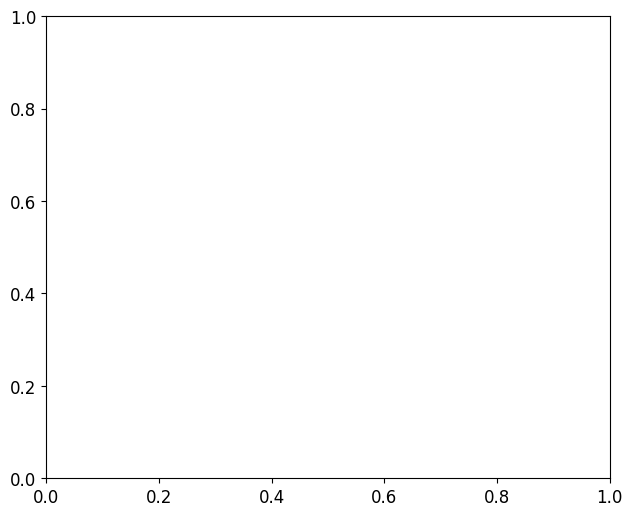

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files  # 파일 다운로드용

# ==========================================
# 9. 고화질 결과 저장 및 다운로드 (추가 실행)
# ==========================================

# 폰트 및 그래프 스타일 설정 (선택 사항)
plt.rcParams.update({'font.size': 12})

# -------------------------------------------------------
# [저장 1] Exact vs PINN 비교 (Contours)
# -------------------------------------------------------
plt.figure(figsize=(16, 6))

# 왼쪽: 정답
plt.subplot(1, 2, 1)
plt.contourf(u_exact_img, levels=100, cmap='RdBu_r')
plt.title(f"Exact HR (Ground Truth)\nL={L_max}", fontsize=14)
plt.colorbar()
plt.axis('off')

# 오른쪽: PINN 예측
plt.subplot(1, 2, 2)
plt.contourf(u_pinn_img, levels=100, cmap='RdBu_r')
plt.title(f"PINN Predicted HR (Super-Resolution)\nwith Fourier Embedding", fontsize=14)
plt.colorbar()
plt.axis('off')

plt.tight_layout()
# dpi=300: 고해상도 저장
plt.savefig("Result_1_Comparison.png", dpi=300, bbox_inches='tight')
plt.close() # 화면 출력 닫기 (메모리 절약)
print("✅ Result_1_Comparison.png 저장 완료")

# -------------------------------------------------------
# [저장 2] Error Map
# -------------------------------------------------------
plt.figure(figsize=(8, 6))
error_map = np.abs(u_exact_img - u_pinn_img)
plt.contourf(error_map, levels=100, cmap='inferno')
plt.colorbar(format='%.0e') # 지수 표기법 (e.g., 1e-3)
plt.title(f"Absolute Error Map (|True - Pred|)", fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.savefig("Result_2_ErrorMap.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ Result_2_ErrorMap.png 저장 완료")

# -------------------------------------------------------
# [저장 3] Loss History & Slice Plot
# -------------------------------------------------------
plt.figure(figsize=(18, 5))

# (3-1) Loss History
plt.subplot(1, 2, 1)
if 'loss_history' in globals() and len(loss_history) > 0:
    plt.plot(loss_history, 'b-', linewidth=1.5, label='Total Loss')
    plt.yscale('log') # 로그 스케일
    plt.title('Training Loss History (Log Scale)', fontsize=14)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.legend()
else:
    plt.text(0.5, 0.5, "Loss history not found", ha='center')

# (3-2) Slice Plot (y=2.0 지점, 정규화 좌표로는 0.5)
plt.subplot(1, 2, 2)

# HR 사이즈가 400이라고 가정 (코드에 있는 400 사용)
hr_size = u_exact_img.shape[0]
slice_y_coord = 2.0
# L_max(4.0) 내에서 2.0의 비율을 인덱스로 변환
slice_idx = int((slice_y_coord / L_max) * hr_size)
# 인덱스가 범위를 벗어나지 않게 조정
slice_idx = min(slice_idx, hr_size - 1)

x_axis = np.linspace(0, L_max, hr_size)
u_exact_slice = u_exact_img[slice_idx, :]
u_pred_slice = u_pinn_img[slice_idx, :]

plt.plot(x_axis, u_exact_slice, 'k-', linewidth=2, label=f'Exact (y={slice_y_coord})')
plt.plot(x_axis, u_pred_slice, 'r--', linewidth=2, label='PINN Prediction')

plt.title(f'U-Velocity Profile at y={slice_y_coord}', fontsize=14)
plt.xlabel('x coordinate', fontsize=12)
plt.ylabel('u velocity', fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.savefig("Result_3_Analysis.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ Result_3_Analysis.png 저장 완료")

# -------------------------------------------------------
# [다운로드] 내 컴퓨터로 파일 전송
# -------------------------------------------------------
print("\n📥 이미지 파일 다운로드를 시작합니다... (브라우저 팝업 허용 필요)")
try:
    files.download("Result_1_Comparison.png")
    files.download("Result_2_ErrorMap.png")
    files.download("Result_3_Analysis.png")
except Exception as e:
    print(f"다운로드 중 오류 발생 (왼쪽 파일 탐색기에서 직접 다운로드하세요): {e}")

NameError: name 'u_exact_img' is not defined

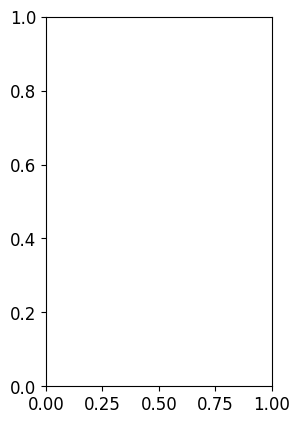

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files  # 파일 다운로드용

# ==========================================
# 9. 고화질 결과 저장 및 다운로드 (추가 실행)
# ==========================================

# 폰트 및 그래프 스타일 설정 (선택 사항)
plt.rcParams.update({'font.size': 12})

# (3-2) Slice Plot (y=2.0 지점, 정규화 좌표로는 0.5)
plt.subplot(1, 2, 2)

# HR 사이즈가 400이라고 가정 (코드에 있는 400 사용)
hr_size = u_exact_img.shape[0]
slice_y_coord_2 = 0.0
# L_max(4.0) 내에서 2.0의 비율을 인덱스로 변환
slice_idx = int((slice_y_coord_2 / L_max) * hr_size)
# 인덱스가 범위를 벗어나지 않게 조정
slice_idx = min(slice_idx, hr_size - 1)

x_axis = np.linspace(0, L_max, hr_size)
u_exact_slice = u_exact_img[slice_idx, :]
u_pred_slice = u_pinn_img[slice_idx, :]

plt.plot(x_axis, u_exact_slice, 'k-', linewidth=2, label=f'Exact (y={slice_y_coord_2})')
plt.plot(x_axis, u_pred_slice, 'r--', linewidth=2, label='PINN Prediction')

plt.title(f'U-Velocity Profile at y={slice_y_coord_2}', fontsize=14)
plt.xlabel('x coordinate', fontsize=12)
plt.ylabel('u velocity', fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.savefig("Result_3_1_Analysis.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ Result_3_1_Analysis.png 저장 완료")

try:
    files.download("Result_3_1_Analysis.png")
except Exception as e:
    print(f"다운로드 중 오류 발생 (왼쪽 파일 탐색기에서 직접 다운로드하세요): {e}")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# ==========================================
# 10. 경계면 (y=0, y=4) 속도 프로파일 확인
# ==========================================

# X축 데이터 생성 (0 ~ 4)
x_axis = np.linspace(0, L_val, HR_SIZE)

# 데이터 추출
# y=0은 배열의 첫 번째 행 (index 0)
u_exact_bottom = u_exact_img[0, :]
u_pred_bottom = u_pinn_img[0, :]

# y=4는 배열의 마지막 행 (index -1)
u_exact_top = u_exact_img[-1, :]
u_pred_top = u_pinn_img[-1, :]

# 그래프 그리기
plt.figure(figsize=(16, 5))

# --- [왼쪽] y=0 (Bottom Boundary) ---
plt.subplot(1, 2, 1)
plt.plot(x_axis, u_exact_bottom, 'k-', linewidth=2, label='Exact (y=0)')
plt.plot(x_axis, u_pred_bottom, 'r--', linewidth=2, label='PINN Prediction')
plt.title('U-Velocity at Bottom Boundary (y=0)', fontsize=14)
plt.xlabel('x coordinate', fontsize=12)
plt.ylabel('u velocity', fontsize=12)
plt.ylim(-0.01, 0.01) # 0 근처를 자세히 보기 위해 y축 범위 제한
plt.grid(True, alpha=0.5)
plt.legend(fontsize=12)

# --- [오른쪽] y=4 (Top Boundary) ---
plt.subplot(1, 2, 2)
plt.plot(x_axis, u_exact_top, 'k-', linewidth=2, label='Exact (y=4)')
plt.plot(x_axis, u_pred_top, 'r--', linewidth=2, label='PINN Prediction')
plt.title('U-Velocity at Top Boundary (y=4)', fontsize=14)
plt.xlabel('x coordinate', fontsize=12)
plt.ylabel('u velocity', fontsize=12)
plt.ylim(-0.01, 0.01) # 0 근처를 자세히 보기 위해 y축 범위 제한
plt.grid(True, alpha=0.5)
plt.legend(fontsize=12)

plt.tight_layout()

# 저장 및 다운로드
plt.savefig("Result_4_Boundary_Profile.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n📥 이미지 파일 다운로드를 시작합니다...")
try:
    files.download("Result_4_Boundary_Profile.png")
except Exception as e:
    print(f"다운로드 중 오류 발생: {e}")

# 정량적 수치 확인
print(f"\n📊 Boundary Error Analysis:")
print(f"   - Max Error at y=0: {np.max(np.abs(u_exact_bottom - u_pred_bottom)):.6f}")
print(f"   - Max Error at y=4: {np.max(np.abs(u_exact_top - u_pred_top)):.6f}")

NameError: name 'L_val' is not defined

In [10]:
a=torch(1.)
b=torch(1.)
c=torch(2.)
mean = torch.mean((a**2)+(b**2)+(c**2))

TypeError: 'module' object is not callable